## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided to help you work with Keras and TensorFlow. It accompanies the bonus chapters for my book. The code is in Python3, using the versions of libraries as of April 2021.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

## Bonus Chapter 3 - Notebook 5: Synthetic Data

We'll create our own data with a program (that is, we'll make synthetic data) 
and train a system to classify it.

Note that training on synthetic data is often a risky proposition if that data
is meant to stand in for real data (that is, measurements in the world). The
problem is that it is all but impossible to generate data that has all of the
variety of real data, and has that variety in the right proportions. Getting it
wrong means we're baking those errors into our system, and if that system is
used in ways that can affect people's lives, such as getting loans or school
admissions or medical diagnoses, then our errors can change their lives. Be
very wary of ever training on synthetic data that's supposed to stand in for
real-world data, or will be used in a system that can affect any living thing.

In [1]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.utils import Sequence
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import np_utils
import numpy as np

random_seed = 42
np.random.seed(random_seed)

image_size = 64
image_width = image_height = image_size
number_of_classes = 5

from keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

Using TensorFlow backend.


In [2]:
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Make a File_Helper for saving and loading files.

save_files = False

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

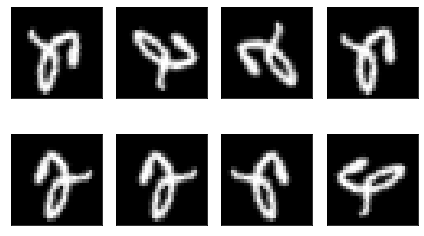

In [4]:
# get MNIST data to show a block of transformed images
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

# Use just one image 
X_train = np.reshape(8 * [X_train[5]], (8, 28, 28, 1))
y_train = 8 * [y_train[5]]

image_generator = ImageDataGenerator(rotation_range=100, horizontal_flip=True)
image_generator.fit(X_train)

for X_batch, y_batch in image_generator.flow(X_train, y_train, batch_size=8, seed=42):
    for i in range(0, 8):
        plt.subplot(2, 4, i+1)
        plt.imshow(X_batch[i].reshape(28, 28), cmap='gray')
        plt.xticks([],[])
        plt.yticks([],[])
    break
plt.tight_layout()
file_helper.save_figure('MNIST-2-IDG')
plt.show()

In [5]:
def plot_accuracy_and_loss(history, plot_title, filename):
    xs = range(len(history.history['accuracy']))

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(xs, history.history['accuracy'], label='train')
    plt.plot(xs, history.history['val_accuracy'], label='test')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+', Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='test')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+', Loss')

    #plt.tight_layout()
    file_helper.save_figure(filename)
    plt.show()

In [6]:
# Make synthetic data. Use random numbers to move the
# points around a little so they're all different.
# For some reason I thought of this as "wubbling."
import numpy as np
from numpy.random import randint, uniform
from keras.preprocessing.image import img_to_array
import cv2
import math
    
def makeSyntheticImage():
    # Create a black image
    half_size = int(image_size/2.0)
    img = np.zeros((image_size, image_size, 3), np.uint8)
    img_type = randint(0, number_of_classes)
    if img_type == 0: # circle
        cx = 32
        cy = 32
        r = half_size * uniform(.6, .9)
        cv2.circle(img, (wub(cx), wub(cy)), int(wub(r)), (255,255,255), 2)
    elif img_type == 1: # plus sign
        cv2.line(img, (wub(32), wub(10)),(wub(32), wub(54)), (255,255,255), 2)
        cv2.line(img, (wub(10), wub(32)),(wub(60), wub(32)), (255,255,255), 2)
    elif img_type == 2: # three  lines
        cv2.line(img,(wub(15), wub(10)), (wub(15), wub(54)), (255,255,255), 2)
        cv2.line(img,(wub(33), wub(10)), (wub(33), wub(54)), (255,255,255), 2)
        cv2.line(img,(wub(51), wub(10)), (wub(51), wub(54)), (255,255,255), 2)
    elif img_type == 3: # Z
        x1 = wub(54)
        y1 = wub(10)
        x2 = wub(10)
        y2 = wub(54)
        cv2.line(img, (wub(10), wub(10)), (x1,y1), (255,255,255), 2)
        cv2.line(img, (x1, y1), (x2, y2), (255, 255, 255), 2)
        cv2.line(img, (x2, y2), (wub(54), wub(54)), (255, 255, 255), 2)
    else: # U
        x1 = wub(10)
        y1 = wub(54)
        x2 = wub(54)
        y2 = wub(54)
        cv2.line(img, (wub(10), wub(10)), (x1,y1), (255,255,255), 2)
        cv2.line(img, (x1, y1), (x2, y2), (255, 255, 255), 2)
        cv2.line(img, (x2, y2), (wub(54), wub(10)), (255, 255, 255), 2)
    sample = img_to_array(img)
    sample = sample[:,:,0]/255.0
    sample = sample.reshape((sample.shape[0], sample.shape[1], 1))
    return (sample, img_type)

# create a little wubble (a uniform, or symmetrical, wobble)
def wub(p):
    range = 5
    return randint(p-range, p+range+1)

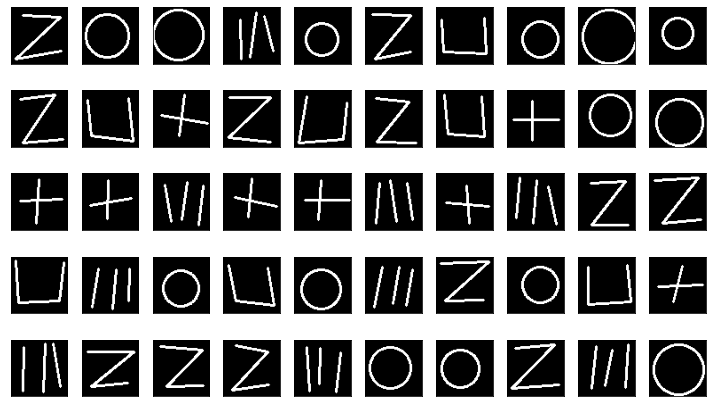

In [7]:
# Show a grid of random synthetic images
np.random.seed(5)
num_rows = 5
num_columns = 10
plt.figure(figsize=(10,6))
for y in range(num_rows):
    for x in range(num_columns):
        index = (y*num_columns)+x
        plt.subplot(num_rows, num_columns, 1 + index)
        (img, label) = makeSyntheticImage()
        img = img.reshape(64, 64)
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        plt.xticks([],[])
        plt.yticks([],[])
plt.tight_layout()
file_helper.save_figure('synthetic-demo')
plt.show()

Build the ImageDataGenerator

Code adapted from
https://towardsdatascience.com/implementing-custom-data-generators-in-keras-de56f013581c

In [8]:
class SyntheticImageGenerator(Sequence):
    def __init__(self, batch_size=32, batches_per_epoch=10):
        self.batch_size = batch_size
        self.batchs_per_epoch = batches_per_epoch
        self.on_epoch_end()
        
    def on_epoch_end(self):
        pass # Maybe we'll want something here one day
            
    def __len__(self):
        # The number of batches per epoch
        return self.batchs_per_epoch
    
    def __getitem__(self, index):
        # Generate and return one batch of data
        X, y = self.__get_data()
        return X,y
    
    def __get_data(self):
        X = []
        y = []
        
        for b in range(self.batch_size):
            # Make one piece of data, append it to the list
            img, label = makeSyntheticImage()
            X.append(img)
            one_hot_label = [0] * 5
            one_hot_label[label] = 1
            y.append(one_hot_label)
            
        X = np.array(X)
        y = np.array(y)
        
        #print("SIG: X.shape=",X.shape,"  y.shape=",y.shape)
        return X, y

In [9]:
# Make a dataset so that we have something to test again when fitting,
# and come up with a validation accuracy and loss.
def make_dataset(number_of_images):
    X = np.zeros(shape=(number_of_images, image_height, image_width, 1))
    y = np.zeros(shape=(number_of_images), dtype='uint8')
    for i in range(number_of_images):
        (sample, label) = makeSyntheticImage()
        X[i] = sample
        y[i] = label
    return (X, y)

In [10]:
# A little routine to set up and run the learning process
def generator_run_and_report(model, plot_title, filename, epochs, 
                             batch_size, verbosity, steps_per_epoch):
    np.random.seed(random_seed)
    
    # make validation data
    (X_test, y_test) = make_dataset(10*batch_size)
    y_test = np_utils.to_categorical(y_test, number_of_classes)
    
    data_generator = SyntheticImageGenerator(batch_size=batch_size, batches_per_epoch=10)
    
    history = model.fit_generator(data_generator,
                                  steps_per_epoch=steps_per_epoch, 
                                  epochs=epochs, verbose=verbosity,
                                  validation_data=(X_test, y_test)
                                 )
    plot_accuracy_and_loss(history, plot_title, filename)
    return history

In [11]:
# build and return our little CNN
def make_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                     input_shape=(image_height, image_width, 1)))
    model.add(Flatten())
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model

Epoch 1/100
256/256 [==============================] - 23s 91ms/step - loss: 0.0135 - accuracy: 0.9949 - val_loss: 6.6040e-05 - val_accuracy: 1.0000
Epoch 2/100
256/256 [==============================] - 24s 93ms/step - loss: 4.8551e-05 - accuracy: 1.0000 - val_loss: 2.1651e-05 - val_accuracy: 1.0000
Epoch 3/100
256/256 [==============================] - 26s 102ms/step - loss: 1.3632e-05 - accuracy: 1.0000 - val_loss: 1.9113e-04 - val_accuracy: 1.0000
Epoch 4/100
256/256 [==============================] - 25s 99ms/step - loss: 8.7313e-06 - accuracy: 1.0000 - val_loss: 3.0501e-05 - val_accuracy: 1.0000
Epoch 5/100
256/256 [==============================] - 24s 92ms/step - loss: 4.2251e-06 - accuracy: 1.0000 - val_loss: 2.0944e-05 - val_accuracy: 1.0000
Epoch 6/100
256/256 [==============================] - 24s 94ms/step - loss: 4.3129e-06 - accuracy: 1.0000 - val_loss: 2.0048e-05 - val_accuracy: 1.0000
Epoch 7/100
256/256 [==============================] - 23s 91ms/step - loss: 1.3030e-

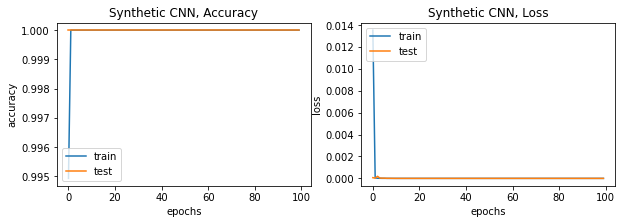

In [15]:
np.random.seed(random_seed)

model = make_model()

# steps_per_epoch / batch_size must be an integer (power of 2?) or we get a warning
history = generator_run_and_report(model, 'Synthetic CNN', 'Synthetic-CNN',
                                   epochs=100, batch_size=64, 
                                   verbosity=1, steps_per_epoch = 256)